# Turing version


Goal is to make this match the sunode version and test. So far this is just copied from https://turinglang.org/v0.30/tutorials/10-bayesian-differential-equations/

As in the sunode version, we will use both pred and prey observations

In [1]:
using Turing
using DifferentialEquations

# Load StatsPlots for visualizations and diagnostics.
using StatsPlots

using LinearAlgebra

# Set a seed for reproducibility.
using Random
Random.seed!(14);

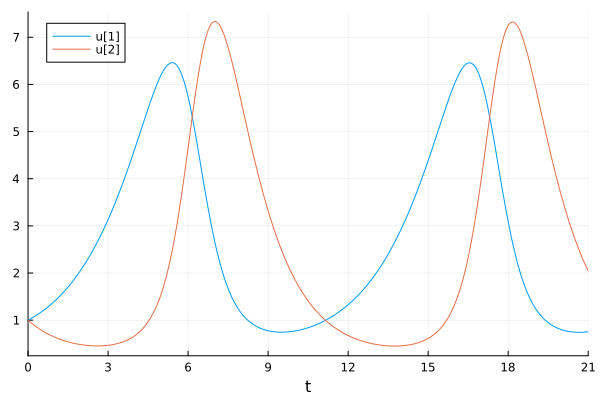

In [2]:
# Define Lotka-Volterra model.
function lotka_volterra(du, u, p, t)
    # Model parameters.
    α, β, γ, δ = p
    # Current state.
    x, y = u

    # Evaluate differential equations.
    du[1] = (α - β * y) * x # prey
    du[2] = (δ * x - γ) * y # predator

    return nothing
end

# Define initial-value problem.
u0 = [1.0, 1.0]
p = [.5,.2,.8,.3]
tspan = (0.0, 21.0)
prob = ODEProblem(lotka_volterra, u0, tspan, p)

# Plot simulation.
plot(solve(prob,  TRBDF2()))

Data from the Sunode version

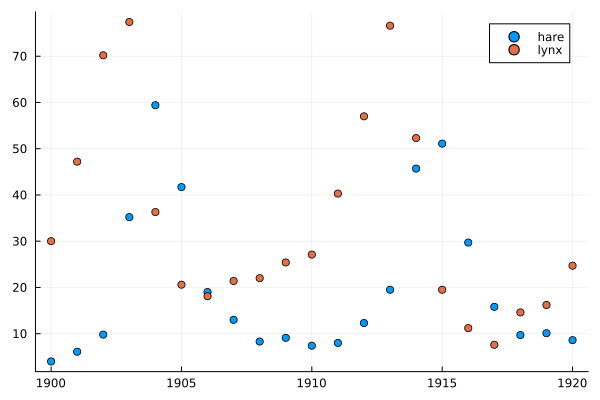

In [3]:
time = collect(range(1900, 1920))
lynx_data = [
    4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
    8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6
]
hare_data = [
    30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4,
    27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7
]
scatter(time, lynx_data, label="hare")
scatter!(time, hare_data, label="lynx")

In [4]:
odedata = collect(transpose(hcat(hare_data, lynx_data)))

2×21 Matrix{Float64}:
 30.0  47.2  70.2  77.4  36.3  20.6  …  19.5  11.2   7.6  14.6  16.2  24.7
  4.0   6.1   9.8  35.2  59.4  41.7     51.1  29.7  15.8   9.7  10.1   8.6

In [5]:
using Distributions

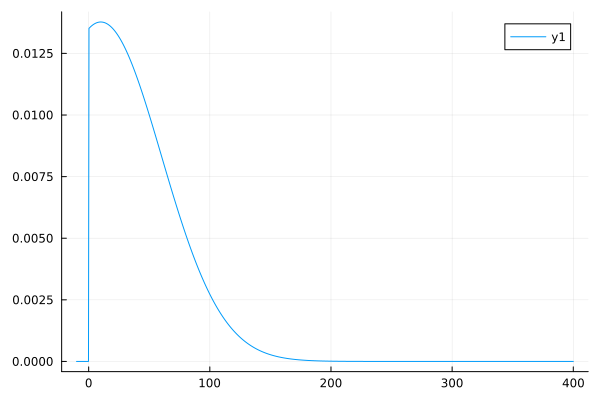

In [6]:
test = truncated(Normal(10,50);lower = 0., upper = Inf)
t= collect(range(-10,400, length = 1000))
plot(t, pdf.(test, t))

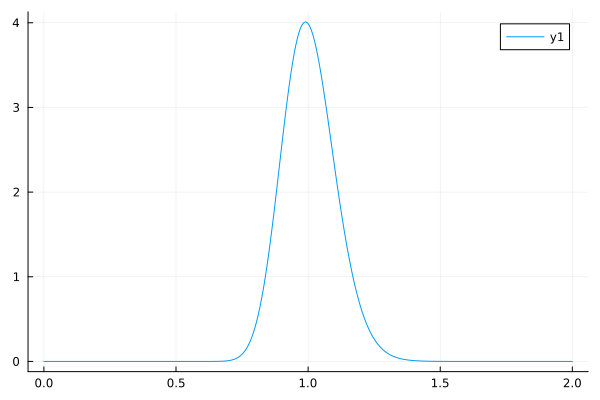

In [7]:
test = LogNormal(0,.1)
t= collect(range(0,2, length = 1000))
plot(t, pdf.(test, t))

In [8]:
@model function fitlv(data, prob)
    # Prior distributions.
    x0 ~ truncated(Normal(10,50);lower = 0.1, upper = Inf)
    y0 ~ truncated(Normal(10,50);lower = 0.1, upper = Inf)
     
    # Compute the parameters of the ode based on our prior parameters
    α ~ truncated(Normal(.5, 1); lower=0, upper=2)
    β ~ truncated(Normal(.5, 1); lower=0, upper=2)
    γ ~ truncated(Normal(.5, 1); lower=0, upper=2)
    δ ~ truncated(Normal(.5, 1); lower=0, upper=2)
    σ ~ truncated(Normal(0,1);lower = 0, upper = Inf)
 

    # Simulate Lotka-Volterra model. 
    p = [α, β, γ, δ]
    u0 = [x0, y0]
    predicted = solve(prob,  TRBDF2(); u0=u0, p=p, saveat=time.-1900)

    # Observations.
    for i in 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ^2 * I)
    end

    return nothing
end

fitlv (generic function with 2 methods)

In [8]:
@model function fitlv_2(data, prob)
    # Prior distributions.
    x0 ~ truncated(Normal(10,50);lower = 0.1, upper = Inf)
    y0 ~ truncated(Normal(10,50);lower = 0.1, upper = Inf)
    ratio ~ Beta(0.5,0.5)
    fixed_hares ~ truncated(Normal(0,50);lower = 0, upper = Inf)
    fixed_lynx  = fixed_hares * ratio
    period ~ Gamma(100, 0.10) # mean 10, std 1 
    freq = 2 * pi / period

    # Why not use lognormal directly?
    #log_speed_ratio ~ Normal(0,0.1)
    #speed_ratio =  exp(log_speed_ratio)
    speed_ratio ~ LogNormal(0,0.1)

    # Compute the parameters of the ode based on our prior parameters
    α =  freq * speed_ratio * ratio 
    β =  freq * speed_ratio / fixed_hares
    γ =  freq / speed_ratio / ratio
    δ =  freq / speed_ratio / fixed_hares / ratio
    σ ~ truncated(Normal(0,1);lower = 0, upper = Inf)
 

    # Simulate Lotka-Volterra model. 
    p = [α, β, γ, δ]
    u0 = [x0, y0]
    predicted = solve(prob,  TRBDF2(); u0=u0, p=p, saveat=time.-1900)

    # Observations.
    for i in 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ^2 * I)
    end

    return nothing
end


fitlv (generic function with 2 methods)

TODO:   Figure out how to keep it from erroring . With the un-reparammeterized version, it is fine and fast.  So perhaps redo sunode that way too and screw it.

In [9]:

model = fitlv(odedata, prob)


DynamicPPL.Model{typeof(fitlv), (:data, :prob), (), (), Tuple{Matrix{Float64}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(lotka_volterra), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCache{Nothing, Nothing, Nothing}}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}}, Tuple{}, DynamicPPL.DefaultContext}(fitlv, (data = [30.0 47.2 … 16.2 24.7; 4.0 6.1 … 10.1 8.6], prob = ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(lotka_volterra), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCach

In [10]:

# Sample 3 independent chains with forward-mode automatic differentiation (the default).
chain = sample(model, NUTS(), MCMCSerial(), 1000, 3,progress=false)

Sampling (Chain 1 of 3)   0%|                           |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/ronaldlegere/.julia/packages/Turing/tdsVz/src/mcmc/hmc.jl:191
Sampling (Chain 1 of 3)   0%|▏                          |  ETA: 0:04:51


Sampling (Chain 1 of 3)   1%|▎                          |  ETA: 0:03:17


Sampling (Chain 1 of 3)   1%|▍                          |  ETA: 0:02:25


Sampling (Chain 1 of 3)   2%|▌                          |  ETA: 0:01:52
Sampling (Chain 1 of 3)   2%|▋                          |  ETA: 0:01:31


Sampling (Chain 1 of 3)   3%|▊                          |  ETA: 0:01:20


Sampling (Chain 1 of 3)   3%|▉                          |  ETA: 0:01:11


Sampling (Chain 1 of 3)   4%|█                          |  ETA: 0:01:03
Sampling (Chain 1 of 3)   4%|█▏                         |  ETA: 0:00:58


Sampling (Chain 1 of 3)   5%|█▎                         |  ETA: 0:00:53
Sampling (Chain 1 of 3)   5%|█▍                         |  ETA: 0:00:49


Sampling (Chain 1 of 3)   6%|█▌                         |  ETA: 0:00:45
Sampling (Chain 1 of 3)   6%|█▋                         |  ETA: 0:00:43


Sampling (Chain 1 of 3)   7%|█▊                         |  ETA: 0:00:40
Sampling (Chain 1 of 3)   7%|█▉                         |  ETA: 0:00:39


Sampling (Chain 1 of 3)   7%|██                         |  ETA: 0:00:38


Sampling (Chain 1 of 3)   8%|██▏                        |  ETA: 0:00:40


Sampling (Chain 1 of 3)   8%|██▎                        |  ETA: 0:00:39


Sampling (Chain 1 of 3)   9%|██▍                        |  ETA: 0:00:39


Sampling (Chain 1 of 3)   9%|██▌                        |  ETA: 0:00:37
Sampling (Chain 1 of 3)  10%|██▋                        |  ETA: 0:00:36


Sampling (Chain 1 of 3)  10%|██▊                        |  ETA: 0:00:35


Sampling (Chain 1 of 3)  11%|██▉                        |  ETA: 0:00:35


Sampling (Chain 1 of 3)  11%|███                        |  ETA: 0:00:34


Sampling (Chain 1 of 3)  12%|███▏                       |  ETA: 0:00:34


Sampling (Chain 1 of 3)  12%|███▎                       |  ETA: 0:00:33


Sampling (Chain 1 of 3)  13%|███▍                       |  ETA: 0:00:33


Sampling (Chain 1 of 3)  13%|███▌                       |  ETA: 0:00:33


Sampling (Chain 1 of 3)  14%|███▋                       |  ETA: 0:00:32


Sampling (Chain 1 of 3)  14%|███▊                       |  ETA: 0:00:32


Sampling (Chain 1 of 3)  14%|███▉                       |  ETA: 0:00:32


Sampling (Chain 1 of 3)  15%|████                       |  ETA: 0:00:31


Sampling (Chain 1 of 3)  15%|████▏                      |  ETA: 0:00:31


Sampling (Chain 1 of 3)  16%|████▎                      |  ETA: 0:00:30
Sampling (Chain 1 of 3)  16%|████▍                      |  ETA: 0:00:30


Sampling (Chain 1 of 3)  17%|████▌                      |  ETA: 0:00:29


Sampling (Chain 1 of 3)  17%|████▋                      |  ETA: 0:00:29
Sampling (Chain 1 of 3)  18%|████▊                      |  ETA: 0:00:28


Sampling (Chain 1 of 3)  18%|████▉                      |  ETA: 0:00:28
Sampling (Chain 1 of 3)  19%|█████                      |  ETA: 0:00:27


Sampling (Chain 1 of 3)  19%|█████▏                     |  ETA: 0:00:27
Sampling (Chain 1 of 3)  20%|█████▎                     |  ETA: 0:00:26


Sampling (Chain 1 of 3)  20%|█████▍                     |  ETA: 0:00:26
Sampling (Chain 1 of 3)  21%|█████▌                     |  ETA: 0:00:25


Sampling (Chain 1 of 3)  21%|█████▋                     |  ETA: 0:00:25
Sampling (Chain 1 of 3)  21%|█████▊                     |  ETA: 0:00:24


Sampling (Chain 1 of 3)  22%|█████▉                     |  ETA: 0:00:24
Sampling (Chain 1 of 3)  22%|██████                     |  ETA: 0:00:24


Sampling (Chain 1 of 3)  23%|██████▏                    |  ETA: 0:00:23
Sampling (Chain 1 of 3)  23%|██████▎                    |  ETA: 0:00:23


Sampling (Chain 1 of 3)  24%|██████▍                    |  ETA: 0:00:23
Sampling (Chain 1 of 3)  24%|██████▌                    |  ETA: 0:00:22


Sampling (Chain 1 of 3)  25%|██████▋                    |  ETA: 0:00:22
Sampling (Chain 1 of 3)  25%|██████▊                    |  ETA: 0:00:22


Sampling (Chain 1 of 3)  26%|██████▉                    |  ETA: 0:00:21
Sampling (Chain 1 of 3)  26%|███████                    |  ETA: 0:00:21


Sampling (Chain 1 of 3)  27%|███████▏                   |  ETA: 0:00:21
Sampling (Chain 1 of 3)  27%|███████▎                   |  ETA: 0:00:20


Sampling (Chain 1 of 3)  28%|███████▍                   |  ETA: 0:00:20
Sampling (Chain 1 of 3)  28%|███████▌                   |  ETA: 0:00:20


Sampling (Chain 1 of 3)  28%|███████▋                   |  ETA: 0:00:20
Sampling (Chain 1 of 3)  29%|███████▊                   |  ETA: 0:00:19


Sampling (Chain 1 of 3)  29%|████████                   |  ETA: 0:00:19
Sampling (Chain 1 of 3)  30%|████████▏                  |  ETA: 0:00:19


Sampling (Chain 1 of 3)  30%|████████▎                  |  ETA: 0:00:19
Sampling (Chain 1 of 3)  31%|████████▍                  |  ETA: 0:00:19


Sampling (Chain 1 of 3)  31%|████████▌                  |  ETA: 0:00:18
Sampling (Chain 1 of 3)  32%|████████▋                  |  ETA: 0:00:18


Sampling (Chain 1 of 3)  32%|████████▊                  |  ETA: 0:00:18


Sampling (Chain 1 of 3)  33%|████████▉                  |  ETA: 0:00:18


Sampling (Chain 1 of 3)  33%|█████████                  |  ETA: 0:00:18
Sampling (Chain 1 of 3)  34%|█████████▏                 |  ETA: 0:00:18


Sampling (Chain 1 of 3)  34%|█████████▎                 |  ETA: 0:00:18


Sampling (Chain 1 of 3)  35%|█████████▍                 |  ETA: 0:00:18


Sampling (Chain 1 of 3)  35%|█████████▌                 |  ETA: 0:00:17


Sampling (Chain 1 of 3)  35%|█████████▋                 |  ETA: 0:00:17


Sampling (Chain 1 of 3)  36%|█████████▊                 |  ETA: 0:00:17


Sampling (Chain 1 of 3)  36%|█████████▉                 |  ETA: 0:00:17


Sampling (Chain 1 of 3)  37%|██████████                 |  ETA: 0:00:17


Sampling (Chain 1 of 3)  37%|██████████▏                |  ETA: 0:00:17


Sampling (Chain 1 of 3)  38%|██████████▎                |  ETA: 0:00:17


Sampling (Chain 1 of 3)  38%|██████████▍                |  ETA: 0:00:17


Sampling (Chain 1 of 3)  39%|██████████▌                |  ETA: 0:00:16


Sampling (Chain 1 of 3)  39%|██████████▋                |  ETA: 0:00:16


Sampling (Chain 1 of 3)  40%|██████████▊                |  ETA: 0:00:16


Sampling (Chain 1 of 3)  40%|██████████▉                |  ETA: 0:00:16


Sampling (Chain 1 of 3)  41%|███████████                |  ETA: 0:00:16


Sampling (Chain 1 of 3)  41%|███████████▏               |  ETA: 0:00:16


Sampling (Chain 1 of 3)  42%|███████████▎               |  ETA: 0:00:16


Sampling (Chain 1 of 3)  42%|███████████▍               |  ETA: 0:00:16


Sampling (Chain 1 of 3)  42%|███████████▌               |  ETA: 0:00:15
Sampling (Chain 1 of 3)  43%|███████████▋               |  ETA: 0:00:15


Sampling (Chain 1 of 3)  43%|███████████▊               |  ETA: 0:00:15
Sampling (Chain 1 of 3)  44%|███████████▉               |  ETA: 0:00:15


Sampling (Chain 1 of 3)  44%|████████████               |  ETA: 0:00:15


Sampling (Chain 1 of 3)  45%|████████████▏              |  ETA: 0:00:15


Sampling (Chain 1 of 3)  45%|████████████▎              |  ETA: 0:00:15


Sampling (Chain 1 of 3)  46%|████████████▍              |  ETA: 0:00:14


Sampling (Chain 1 of 3)  46%|████████████▌              |  ETA: 0:00:14


Sampling (Chain 1 of 3)  47%|████████████▋              |  ETA: 0:00:14


Sampling (Chain 1 of 3)  47%|████████████▊              |  ETA: 0:00:14


Sampling (Chain 1 of 3)  48%|████████████▉              |  ETA: 0:00:14


Sampling (Chain 1 of 3)  48%|█████████████              |  ETA: 0:00:14


Sampling (Chain 1 of 3)  49%|█████████████▏             |  ETA: 0:00:14


Sampling (Chain 1 of 3)  49%|█████████████▎             |  ETA: 0:00:14
Sampling (Chain 1 of 3)  49%|█████████████▍             |  ETA: 0:00:13


Sampling (Chain 1 of 3)  50%|█████████████▌             |  ETA: 0:00:13


Sampling (Chain 1 of 3)  50%|█████████████▋             |  ETA: 0:00:13


Sampling (Chain 1 of 3)  51%|█████████████▊             |  ETA: 0:00:13


Sampling (Chain 1 of 3)  51%|█████████████▉             |  ETA: 0:00:13


Sampling (Chain 1 of 3)  52%|██████████████             |  ETA: 0:00:13


Sampling (Chain 1 of 3)  52%|██████████████▏            |  ETA: 0:00:13


Sampling (Chain 1 of 3)  53%|██████████████▎            |  ETA: 0:00:13


Sampling (Chain 1 of 3)  53%|██████████████▍            |  ETA: 0:00:12


Sampling (Chain 1 of 3)  54%|██████████████▌            |  ETA: 0:00:12


Sampling (Chain 1 of 3)  54%|██████████████▋            |  ETA: 0:00:12
Sampling (Chain 1 of 3)  55%|██████████████▊            |  ETA: 0:00:12


Sampling (Chain 1 of 3)  55%|██████████████▉            |  ETA: 0:00:12


Sampling (Chain 1 of 3)  56%|███████████████            |  ETA: 0:00:12


Sampling (Chain 1 of 3)  56%|███████████████▏           |  ETA: 0:00:12


Sampling (Chain 1 of 3)  56%|███████████████▎           |  ETA: 0:00:11
Sampling (Chain 1 of 3)  57%|███████████████▍           |  ETA: 0:00:11


Sampling (Chain 1 of 3)  57%|███████████████▌           |  ETA: 0:00:11
Sampling (Chain 1 of 3)  58%|███████████████▋           |  ETA: 0:00:11


Sampling (Chain 1 of 3)  58%|███████████████▊           |  ETA: 0:00:11


Sampling (Chain 1 of 3)  59%|███████████████▉           |  ETA: 0:00:11


Sampling (Chain 1 of 3)  59%|████████████████           |  ETA: 0:00:11


Sampling (Chain 1 of 3)  60%|████████████████▏          |  ETA: 0:00:11


Sampling (Chain 1 of 3)  60%|████████████████▎          |  ETA: 0:00:11


Sampling (Chain 1 of 3)  61%|████████████████▍          |  ETA: 0:00:10
Sampling (Chain 1 of 3)  61%|████████████████▌          |  ETA: 0:00:10


Sampling (Chain 1 of 3)  62%|████████████████▋          |  ETA: 0:00:10


Sampling (Chain 1 of 3)  62%|████████████████▊          |  ETA: 0:00:10


Sampling (Chain 1 of 3)  63%|████████████████▉          |  ETA: 0:00:10


Sampling (Chain 1 of 3)  63%|█████████████████          |  ETA: 0:00:10


Sampling (Chain 1 of 3)  63%|█████████████████▏         |  ETA: 0:00:10


Sampling (Chain 1 of 3)  64%|█████████████████▎         |  ETA: 0:00:10


Sampling (Chain 1 of 3)  64%|█████████████████▍         |  ETA: 0:00:09


Sampling (Chain 1 of 3)  65%|█████████████████▌         |  ETA: 0:00:09


Sampling (Chain 1 of 3)  65%|█████████████████▋         |  ETA: 0:00:09


Sampling (Chain 1 of 3)  66%|█████████████████▊         |  ETA: 0:00:09


Sampling (Chain 1 of 3)  66%|█████████████████▉         |  ETA: 0:00:09
Sampling (Chain 1 of 3)  67%|██████████████████         |  ETA: 0:00:09


Sampling (Chain 1 of 3)  67%|██████████████████▏        |  ETA: 0:00:09


Sampling (Chain 1 of 3)  68%|██████████████████▎        |  ETA: 0:00:08
Sampling (Chain 1 of 3)  68%|██████████████████▍        |  ETA: 0:00:08


Sampling (Chain 1 of 3)  69%|██████████████████▌        |  ETA: 0:00:08


Sampling (Chain 1 of 3)  69%|██████████████████▋        |  ETA: 0:00:08


Sampling (Chain 1 of 3)  70%|██████████████████▊        |  ETA: 0:00:08


Sampling (Chain 1 of 3)  70%|██████████████████▉        |  ETA: 0:00:08
Sampling (Chain 1 of 3)  70%|███████████████████        |  ETA: 0:00:08


Sampling (Chain 1 of 3)  71%|███████████████████▏       |  ETA: 0:00:08


Sampling (Chain 1 of 3)  71%|███████████████████▎       |  ETA: 0:00:08


Sampling (Chain 1 of 3)  72%|███████████████████▍       |  ETA: 0:00:07


Sampling (Chain 1 of 3)  72%|███████████████████▌       |  ETA: 0:00:07


Sampling (Chain 1 of 3)  73%|███████████████████▋       |  ETA: 0:00:07
Sampling (Chain 1 of 3)  73%|███████████████████▊       |  ETA: 0:00:07


Sampling (Chain 1 of 3)  74%|███████████████████▉       |  ETA: 0:00:07


Sampling (Chain 1 of 3)  74%|████████████████████       |  ETA: 0:00:07
Sampling (Chain 1 of 3)  75%|████████████████████▏      |  ETA: 0:00:07


Sampling (Chain 1 of 3)  75%|████████████████████▎      |  ETA: 0:00:07


Sampling (Chain 1 of 3)  76%|████████████████████▍      |  ETA: 0:00:06


Sampling (Chain 1 of 3)  76%|████████████████████▌      |  ETA: 0:00:06


Sampling (Chain 1 of 3)  77%|████████████████████▋      |  ETA: 0:00:06


Sampling (Chain 1 of 3)  77%|████████████████████▊      |  ETA: 0:00:06
Sampling (Chain 1 of 3)  77%|████████████████████▉      |  ETA: 0:00:06


Sampling (Chain 1 of 3)  78%|█████████████████████      |  ETA: 0:00:06


Sampling (Chain 1 of 3)  78%|█████████████████████▏     |  ETA: 0:00:06


Sampling (Chain 1 of 3)  79%|█████████████████████▎     |  ETA: 0:00:06


Sampling (Chain 1 of 3)  79%|█████████████████████▍     |  ETA: 0:00:05


Sampling (Chain 1 of 3)  80%|█████████████████████▌     |  ETA: 0:00:05
Sampling (Chain 1 of 3)  80%|█████████████████████▋     |  ETA: 0:00:05


Sampling (Chain 1 of 3)  81%|█████████████████████▊     |  ETA: 0:00:05


Sampling (Chain 1 of 3)  81%|█████████████████████▉     |  ETA: 0:00:05


Sampling (Chain 1 of 3)  82%|██████████████████████     |  ETA: 0:00:05


Sampling (Chain 1 of 3)  82%|██████████████████████▏    |  ETA: 0:00:05


Sampling (Chain 1 of 3)  83%|██████████████████████▎    |  ETA: 0:00:05


Sampling (Chain 1 of 3)  83%|██████████████████████▍    |  ETA: 0:00:04


Sampling (Chain 1 of 3)  84%|██████████████████████▌    |  ETA: 0:00:04


Sampling (Chain 1 of 3)  84%|██████████████████████▋    |  ETA: 0:00:04


Sampling (Chain 1 of 3)  84%|██████████████████████▊    |  ETA: 0:00:04


Sampling (Chain 1 of 3)  85%|██████████████████████▉    |  ETA: 0:00:04


Sampling (Chain 1 of 3)  85%|███████████████████████    |  ETA: 0:00:04


Sampling (Chain 1 of 3)  86%|███████████████████████▏   |  ETA: 0:00:04


Sampling (Chain 1 of 3)  86%|███████████████████████▎   |  ETA: 0:00:04


Sampling (Chain 1 of 3)  87%|███████████████████████▍   |  ETA: 0:00:03


Sampling (Chain 1 of 3)  87%|███████████████████████▌   |  ETA: 0:00:03
Sampling (Chain 1 of 3)  88%|███████████████████████▊   |  ETA: 0:00:03


Sampling (Chain 1 of 3)  88%|███████████████████████▉   |  ETA: 0:00:03


Sampling (Chain 1 of 3)  89%|████████████████████████   |  ETA: 0:00:03


Sampling (Chain 1 of 3)  89%|████████████████████████▏  |  ETA: 0:00:03


Sampling (Chain 1 of 3)  90%|████████████████████████▎  |  ETA: 0:00:03


Sampling (Chain 1 of 3)  90%|████████████████████████▍  |  ETA: 0:00:03
Sampling (Chain 1 of 3)  91%|████████████████████████▌  |  ETA: 0:00:02


Sampling (Chain 1 of 3)  91%|████████████████████████▋  |  ETA: 0:00:02
Sampling (Chain 1 of 3)  91%|████████████████████████▊  |  ETA: 0:00:02


Sampling (Chain 1 of 3)  92%|████████████████████████▉  |  ETA: 0:00:02


Sampling (Chain 1 of 3)  92%|█████████████████████████  |  ETA: 0:00:02
Sampling (Chain 1 of 3)  93%|█████████████████████████▏ |  ETA: 0:00:02


Sampling (Chain 1 of 3)  93%|█████████████████████████▎ |  ETA: 0:00:02
Sampling (Chain 1 of 3)  94%|█████████████████████████▍ |  ETA: 0:00:02


Sampling (Chain 1 of 3)  94%|█████████████████████████▌ |  ETA: 0:00:01


Sampling (Chain 1 of 3)  95%|█████████████████████████▋ |  ETA: 0:00:01


Sampling (Chain 1 of 3)  95%|█████████████████████████▊ |  ETA: 0:00:01


Sampling (Chain 1 of 3)  96%|█████████████████████████▉ |  ETA: 0:00:01


Sampling (Chain 1 of 3)  96%|██████████████████████████ |  ETA: 0:00:01


Sampling (Chain 1 of 3)  97%|██████████████████████████▏|  ETA: 0:00:01


Sampling (Chain 1 of 3)  97%|██████████████████████████▎|  ETA: 0:00:01


Sampling (Chain 1 of 3)  98%|██████████████████████████▍|  ETA: 0:00:01


Sampling (Chain 1 of 3)  98%|██████████████████████████▌|  ETA: 0:00:01


Sampling (Chain 1 of 3)  98%|██████████████████████████▋|  ETA: 0:00:00


Sampling (Chain 1 of 3)  99%|██████████████████████████▊|  ETA: 0:00:00


Sampling (Chain 1 of 3)  99%|██████████████████████████▉|  ETA: 0:00:00


Sampling (Chain 1 of 3) 100%|███████████████████████████|  ETA: 0:00:00


Sampling (Chain 1 of 3) 100%|███████████████████████████| Time: 0:00:25
Sampling (Chain 2 of 3)   0%|                           |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/ronaldlegere/.julia/packages/Turing/tdsVz/src/mcmc/hmc.jl:191


Sampling (Chain 2 of 3)   0%|▏                          |  ETA: 0:00:21


Sampling (Chain 2 of 3)   1%|▎                          |  ETA: 0:00:25


Sampling (Chain 2 of 3)   1%|▍                          |  ETA: 0:00:25


Sampling (Chain 2 of 3)   2%|▌                          |  ETA: 0:00:26


Sampling (Chain 2 of 3)   2%|▋                          |  ETA: 0:00:25


Sampling (Chain 2 of 3)   3%|▊                          |  ETA: 0:00:25
Sampling (Chain 2 of 3)   3%|▉                          |  ETA: 0:00:24


Sampling (Chain 2 of 3)   4%|█                          |  ETA: 0:00:23


Sampling (Chain 2 of 3)   4%|█▏                         |  ETA: 0:00:23


Sampling (Chain 2 of 3)   5%|█▎                         |  ETA: 0:00:23
Sampling (Chain 2 of 3)   5%|█▍                         |  ETA: 0:00:23


Sampling (Chain 2 of 3)   6%|█▌                         |  ETA: 0:00:22
Sampling (Chain 2 of 3)   6%|█▋                         |  ETA: 0:00:21
Sampling (Chain 2 of 3)   7%|█▊                         |  ETA: 0:00:20
Sampling (Chain 2 of 3)   7%|█▉                         |  ETA: 0:00:19


Sampling (Chain 2 of 3)   7%|██                         |  ETA: 0:00:18


Sampling (Chain 2 of 3)   8%|██▏                        |  ETA: 0:00:19


Sampling (Chain 2 of 3)   8%|██▎                        |  ETA: 0:00:19
Sampling (Chain 2 of 3)   9%|██▍                        |  ETA: 0:00:19


Sampling (Chain 2 of 3)   9%|██▌                        |  ETA: 0:00:19
Sampling (Chain 2 of 3)  10%|██▋                        |  ETA: 0:00:18


Sampling (Chain 2 of 3)  10%|██▊                        |  ETA: 0:00:19


Sampling (Chain 2 of 3)  11%|██▉                        |  ETA: 0:00:20


Sampling (Chain 2 of 3)  11%|███                        |  ETA: 0:00:21
Sampling (Chain 2 of 3)  12%|███▏                       |  ETA: 0:00:20


Sampling (Chain 2 of 3)  12%|███▎                       |  ETA: 0:00:21


Sampling (Chain 2 of 3)  13%|███▍                       |  ETA: 0:00:20


Sampling (Chain 2 of 3)  13%|███▌                       |  ETA: 0:00:21


Sampling (Chain 2 of 3)  14%|███▋                       |  ETA: 0:00:21
Sampling (Chain 2 of 3)  14%|███▊                       |  ETA: 0:00:20


Sampling (Chain 2 of 3)  14%|███▉                       |  ETA: 0:00:20


Sampling (Chain 2 of 3)  15%|████                       |  ETA: 0:00:20


Sampling (Chain 2 of 3)  15%|████▏                      |  ETA: 0:00:20


Sampling (Chain 2 of 3)  16%|████▎                      |  ETA: 0:00:20
Sampling (Chain 2 of 3)  16%|████▍                      |  ETA: 0:00:19


Sampling (Chain 2 of 3)  17%|████▌                      |  ETA: 0:00:19


Sampling (Chain 2 of 3)  17%|████▋                      |  ETA: 0:00:19


Sampling (Chain 2 of 3)  18%|████▊                      |  ETA: 0:00:19


Sampling (Chain 2 of 3)  18%|████▉                      |  ETA: 0:00:19
Sampling (Chain 2 of 3)  19%|█████                      |  ETA: 0:00:19


Sampling (Chain 2 of 3)  19%|█████▏                     |  ETA: 0:00:19


Sampling (Chain 2 of 3)  20%|█████▎                     |  ETA: 0:00:19
Sampling (Chain 2 of 3)  20%|█████▍                     |  ETA: 0:00:19


Sampling (Chain 2 of 3)  21%|█████▌                     |  ETA: 0:00:18
Sampling (Chain 2 of 3)  21%|█████▋                     |  ETA: 0:00:18


Sampling (Chain 2 of 3)  21%|█████▊                     |  ETA: 0:00:18
Sampling (Chain 2 of 3)  22%|█████▉                     |  ETA: 0:00:18
Sampling (Chain 2 of 3)  22%|██████                     |  ETA: 0:00:17


Sampling (Chain 2 of 3)  23%|██████▏                    |  ETA: 0:00:17
Sampling (Chain 2 of 3)  23%|██████▎                    |  ETA: 0:00:17


Sampling (Chain 2 of 3)  24%|██████▍                    |  ETA: 0:00:16
Sampling (Chain 2 of 3)  24%|██████▌                    |  ETA: 0:00:16


Sampling (Chain 2 of 3)  25%|██████▋                    |  ETA: 0:00:16
Sampling (Chain 2 of 3)  25%|██████▊                    |  ETA: 0:00:16


Sampling (Chain 2 of 3)  26%|██████▉                    |  ETA: 0:00:16
Sampling (Chain 2 of 3)  26%|███████                    |  ETA: 0:00:15
Sampling (Chain 2 of 3)  27%|███████▏                   |  ETA: 0:00:15


Sampling (Chain 2 of 3)  27%|███████▎                   |  ETA: 0:00:15
Sampling (Chain 2 of 3)  28%|███████▍                   |  ETA: 0:00:15


Sampling (Chain 2 of 3)  28%|███████▌                   |  ETA: 0:00:15
Sampling (Chain 2 of 3)  28%|███████▋                   |  ETA: 0:00:14


Sampling (Chain 2 of 3)  29%|███████▊                   |  ETA: 0:00:14


Sampling (Chain 2 of 3)  29%|████████                   |  ETA: 0:00:14
Sampling (Chain 2 of 3)  30%|████████▏                  |  ETA: 0:00:14


Sampling (Chain 2 of 3)  30%|████████▎                  |  ETA: 0:00:14
Sampling (Chain 2 of 3)  31%|████████▍                  |  ETA: 0:00:14


Sampling (Chain 2 of 3)  31%|████████▌                  |  ETA: 0:00:14


Sampling (Chain 2 of 3)  32%|████████▋                  |  ETA: 0:00:14
Sampling (Chain 2 of 3)  32%|████████▊                  |  ETA: 0:00:14


Sampling (Chain 2 of 3)  33%|████████▉                  |  ETA: 0:00:14
Sampling (Chain 2 of 3)  33%|█████████                  |  ETA: 0:00:13


Sampling (Chain 2 of 3)  34%|█████████▏                 |  ETA: 0:00:13
Sampling (Chain 2 of 3)  34%|█████████▎                 |  ETA: 0:00:13


Sampling (Chain 2 of 3)  35%|█████████▍                 |  ETA: 0:00:13
Sampling (Chain 2 of 3)  35%|█████████▌                 |  ETA: 0:00:13


Sampling (Chain 2 of 3)  35%|█████████▋                 |  ETA: 0:00:13
Sampling (Chain 2 of 3)  36%|█████████▊                 |  ETA: 0:00:13
Sampling (Chain 2 of 3)  36%|█████████▉                 |  ETA: 0:00:12


Sampling (Chain 2 of 3)  37%|██████████                 |  ETA: 0:00:12
Sampling (Chain 2 of 3)  37%|██████████▏                |  ETA: 0:00:12
Sampling (Chain 2 of 3)  38%|██████████▎                |  ETA: 0:00:12


Sampling (Chain 2 of 3)  38%|██████████▍                |  ETA: 0:00:12
Sampling (Chain 2 of 3)  39%|██████████▌                |  ETA: 0:00:11
Sampling (Chain 2 of 3)  39%|██████████▋                |  ETA: 0:00:11
Sampling (Chain 2 of 3)  40%|██████████▊                |  ETA: 0:00:11


Sampling (Chain 2 of 3)  40%|██████████▉                |  ETA: 0:00:11
Sampling (Chain 2 of 3)  41%|███████████                |  ETA: 0:00:11


Sampling (Chain 2 of 3)  41%|███████████▏               |  ETA: 0:00:11
Sampling (Chain 2 of 3)  42%|███████████▎               |  ETA: 0:00:11
Sampling (Chain 2 of 3)  42%|███████████▍               |  ETA: 0:00:10
Sampling (Chain 2 of 3)  42%|███████████▌               |  ETA: 0:00:10


Sampling (Chain 2 of 3)  43%|███████████▋               |  ETA: 0:00:10
Sampling (Chain 2 of 3)  43%|███████████▊               |  ETA: 0:00:10
Sampling (Chain 2 of 3)  44%|███████████▉               |  ETA: 0:00:10


Sampling (Chain 2 of 3)  44%|████████████               |  ETA: 0:00:10
Sampling (Chain 2 of 3)  45%|████████████▏              |  ETA: 0:00:09
Sampling (Chain 2 of 3)  45%|████████████▎              |  ETA: 0:00:09


Sampling (Chain 2 of 3)  46%|████████████▍              |  ETA: 0:00:09
Sampling (Chain 2 of 3)  46%|████████████▌              |  ETA: 0:00:09
Sampling (Chain 2 of 3)  47%|████████████▋              |  ETA: 0:00:09
Sampling (Chain 2 of 3)  47%|████████████▊              |  ETA: 0:00:09


Sampling (Chain 2 of 3)  48%|████████████▉              |  ETA: 0:00:09
Sampling (Chain 2 of 3)  48%|█████████████              |  ETA: 0:00:09
Sampling (Chain 2 of 3)  49%|█████████████▏             |  ETA: 0:00:08
Sampling (Chain 2 of 3)  49%|█████████████▎             |  ETA: 0:00:08


Sampling (Chain 2 of 3)  49%|█████████████▍             |  ETA: 0:00:08
Sampling (Chain 2 of 3)  50%|█████████████▌             |  ETA: 0:00:08
Sampling (Chain 2 of 3)  50%|█████████████▋             |  ETA: 0:00:08
Sampling (Chain 2 of 3)  51%|█████████████▊             |  ETA: 0:00:08
Sampling (Chain 2 of 3)  51%|█████████████▉             |  ETA: 0:00:08
Sampling (Chain 2 of 3)  52%|██████████████             |  ETA: 0:00:08


Sampling (Chain 2 of 3)  52%|██████████████▏            |  ETA: 0:00:07
Sampling (Chain 2 of 3)  53%|██████████████▎            |  ETA: 0:00:07
Sampling (Chain 2 of 3)  53%|██████████████▍            |  ETA: 0:00:07


Sampling (Chain 2 of 3)  54%|██████████████▌            |  ETA: 0:00:07
Sampling (Chain 2 of 3)  54%|██████████████▋            |  ETA: 0:00:07
Sampling (Chain 2 of 3)  55%|██████████████▊            |  ETA: 0:00:07
Sampling (Chain 2 of 3)  55%|██████████████▉            |  ETA: 0:00:07


Sampling (Chain 2 of 3)  56%|███████████████            |  ETA: 0:00:07
Sampling (Chain 2 of 3)  56%|███████████████▏           |  ETA: 0:00:07
Sampling (Chain 2 of 3)  56%|███████████████▎           |  ETA: 0:00:06
Sampling (Chain 2 of 3)  57%|███████████████▍           |  ETA: 0:00:06


Sampling (Chain 2 of 3)  57%|███████████████▌           |  ETA: 0:00:06
Sampling (Chain 2 of 3)  58%|███████████████▋           |  ETA: 0:00:06
Sampling (Chain 2 of 3)  58%|███████████████▊           |  ETA: 0:00:06
Sampling (Chain 2 of 3)  59%|███████████████▉           |  ETA: 0:00:06
Sampling (Chain 2 of 3)  59%|████████████████           |  ETA: 0:00:06
Sampling (Chain 2 of 3)  60%|████████████████▏          |  ETA: 0:00:06


Sampling (Chain 2 of 3)  60%|████████████████▎          |  ETA: 0:00:06
Sampling (Chain 2 of 3)  61%|████████████████▍          |  ETA: 0:00:06
Sampling (Chain 2 of 3)  61%|████████████████▌          |  ETA: 0:00:06
Sampling (Chain 2 of 3)  62%|████████████████▋          |  ETA: 0:00:05


Sampling (Chain 2 of 3)  62%|████████████████▊          |  ETA: 0:00:05
Sampling (Chain 2 of 3)  63%|████████████████▉          |  ETA: 0:00:05
Sampling (Chain 2 of 3)  63%|█████████████████          |  ETA: 0:00:05
Sampling (Chain 2 of 3)  63%|█████████████████▏         |  ETA: 0:00:05
Sampling (Chain 2 of 3)  64%|█████████████████▎         |  ETA: 0:00:05


Sampling (Chain 2 of 3)  64%|█████████████████▍         |  ETA: 0:00:05
Sampling (Chain 2 of 3)  65%|█████████████████▌         |  ETA: 0:00:05
Sampling (Chain 2 of 3)  65%|█████████████████▋         |  ETA: 0:00:05
Sampling (Chain 2 of 3)  66%|█████████████████▊         |  ETA: 0:00:05
Sampling (Chain 2 of 3)  66%|█████████████████▉         |  ETA: 0:00:05
Sampling (Chain 2 of 3)  67%|██████████████████         |  ETA: 0:00:04


Sampling (Chain 2 of 3)  67%|██████████████████▏        |  ETA: 0:00:04
Sampling (Chain 2 of 3)  68%|██████████████████▎        |  ETA: 0:00:04
Sampling (Chain 2 of 3)  68%|██████████████████▍        |  ETA: 0:00:04
Sampling (Chain 2 of 3)  69%|██████████████████▌        |  ETA: 0:00:04


Sampling (Chain 2 of 3)  69%|██████████████████▋        |  ETA: 0:00:04
Sampling (Chain 2 of 3)  70%|██████████████████▊        |  ETA: 0:00:04
Sampling (Chain 2 of 3)  70%|██████████████████▉        |  ETA: 0:00:04
Sampling (Chain 2 of 3)  70%|███████████████████        |  ETA: 0:00:04
Sampling (Chain 2 of 3)  71%|███████████████████▏       |  ETA: 0:00:04
Sampling (Chain 2 of 3)  71%|███████████████████▎       |  ETA: 0:00:04
Sampling (Chain 2 of 3)  72%|███████████████████▍       |  ETA: 0:00:04


Sampling (Chain 2 of 3)  72%|███████████████████▌       |  ETA: 0:00:04
Sampling (Chain 2 of 3)  73%|███████████████████▋       |  ETA: 0:00:03
Sampling (Chain 2 of 3)  73%|███████████████████▊       |  ETA: 0:00:03
Sampling (Chain 2 of 3)  74%|███████████████████▉       |  ETA: 0:00:03
Sampling (Chain 2 of 3)  74%|████████████████████       |  ETA: 0:00:03
Sampling (Chain 2 of 3)  75%|████████████████████▏      |  ETA: 0:00:03


Sampling (Chain 2 of 3)  75%|████████████████████▎      |  ETA: 0:00:03
Sampling (Chain 2 of 3)  76%|████████████████████▍      |  ETA: 0:00:03
Sampling (Chain 2 of 3)  76%|████████████████████▌      |  ETA: 0:00:03
Sampling (Chain 2 of 3)  77%|████████████████████▋      |  ETA: 0:00:03
Sampling (Chain 2 of 3)  77%|████████████████████▊      |  ETA: 0:00:03
Sampling (Chain 2 of 3)  77%|████████████████████▉      |  ETA: 0:00:03


Sampling (Chain 2 of 3)  78%|█████████████████████      |  ETA: 0:00:03
Sampling (Chain 2 of 3)  78%|█████████████████████▏     |  ETA: 0:00:03
Sampling (Chain 2 of 3)  79%|█████████████████████▎     |  ETA: 0:00:03
Sampling (Chain 2 of 3)  79%|█████████████████████▍     |  ETA: 0:00:02
Sampling (Chain 2 of 3)  80%|█████████████████████▌     |  ETA: 0:00:02
Sampling (Chain 2 of 3)  80%|█████████████████████▋     |  ETA: 0:00:02


Sampling (Chain 2 of 3)  81%|█████████████████████▊     |  ETA: 0:00:02
Sampling (Chain 2 of 3)  81%|█████████████████████▉     |  ETA: 0:00:02
Sampling (Chain 2 of 3)  82%|██████████████████████     |  ETA: 0:00:02
Sampling (Chain 2 of 3)  82%|██████████████████████▏    |  ETA: 0:00:02
Sampling (Chain 2 of 3)  83%|██████████████████████▎    |  ETA: 0:00:02
Sampling (Chain 2 of 3)  83%|██████████████████████▍    |  ETA: 0:00:02
Sampling (Chain 2 of 3)  84%|██████████████████████▌    |  ETA: 0:00:02
Sampling (Chain 2 of 3)  84%|██████████████████████▋    |  ETA: 0:00:02
Sampling (Chain 2 of 3)  84%|██████████████████████▊    |  ETA: 0:00:02


Sampling (Chain 2 of 3)  85%|██████████████████████▉    |  ETA: 0:00:02
Sampling (Chain 2 of 3)  85%|███████████████████████    |  ETA: 0:00:02
Sampling (Chain 2 of 3)  86%|███████████████████████▏   |  ETA: 0:00:02
Sampling (Chain 2 of 3)  86%|███████████████████████▎   |  ETA: 0:00:02
Sampling (Chain 2 of 3)  87%|███████████████████████▍   |  ETA: 0:00:01


Sampling (Chain 2 of 3)  87%|███████████████████████▌   |  ETA: 0:00:01
Sampling (Chain 2 of 3)  88%|███████████████████████▊   |  ETA: 0:00:01
Sampling (Chain 2 of 3)  88%|███████████████████████▉   |  ETA: 0:00:01
Sampling (Chain 2 of 3)  89%|████████████████████████   |  ETA: 0:00:01
Sampling (Chain 2 of 3)  89%|████████████████████████▏  |  ETA: 0:00:01
Sampling (Chain 2 of 3)  90%|████████████████████████▎  |  ETA: 0:00:01


Sampling (Chain 2 of 3)  90%|████████████████████████▍  |  ETA: 0:00:01
Sampling (Chain 2 of 3)  91%|████████████████████████▌  |  ETA: 0:00:01
Sampling (Chain 2 of 3)  91%|████████████████████████▋  |  ETA: 0:00:01
Sampling (Chain 2 of 3)  91%|████████████████████████▊  |  ETA: 0:00:01
Sampling (Chain 2 of 3)  92%|████████████████████████▉  |  ETA: 0:00:01
Sampling (Chain 2 of 3)  92%|█████████████████████████  |  ETA: 0:00:01
Sampling (Chain 2 of 3)  93%|█████████████████████████▏ |  ETA: 0:00:01


Sampling (Chain 2 of 3)  93%|█████████████████████████▎ |  ETA: 0:00:01
Sampling (Chain 2 of 3)  94%|█████████████████████████▍ |  ETA: 0:00:01
Sampling (Chain 2 of 3)  94%|█████████████████████████▌ |  ETA: 0:00:01
Sampling (Chain 2 of 3)  95%|█████████████████████████▋ |  ETA: 0:00:01
Sampling (Chain 2 of 3)  95%|█████████████████████████▊ |  ETA: 0:00:01
Sampling (Chain 2 of 3)  96%|█████████████████████████▉ |  ETA: 0:00:00
Sampling (Chain 2 of 3)  96%|██████████████████████████ |  ETA: 0:00:00
Sampling (Chain 2 of 3)  97%|██████████████████████████▏|  ETA: 0:00:00
Sampling (Chain 2 of 3)  97%|██████████████████████████▎|  ETA: 0:00:00


Sampling (Chain 2 of 3)  98%|██████████████████████████▍|  ETA: 0:00:00
Sampling (Chain 2 of 3)  98%|██████████████████████████▌|  ETA: 0:00:00
Sampling (Chain 2 of 3)  98%|██████████████████████████▋|  ETA: 0:00:00
Sampling (Chain 2 of 3)  99%|██████████████████████████▊|  ETA: 0:00:00
Sampling (Chain 2 of 3)  99%|██████████████████████████▉|  ETA: 0:00:00


Sampling (Chain 2 of 3) 100%|███████████████████████████|  ETA: 0:00:00
Sampling (Chain 2 of 3) 100%|███████████████████████████| Time: 0:00:10
Sampling (Chain 3 of 3)   0%|                           |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /Users/ronaldlegere/.julia/packages/Turing/tdsVz/src/mcmc/hmc.jl:191
Sampling (Chain 3 of 3)   0%|▏                          |  ETA: 0:00:15
Sampling (Chain 3 of 3)   1%|▎                          |  ETA: 0:00:17


Sampling (Chain 3 of 3)   1%|▍                          |  ETA: 0:00:14
Sampling (Chain 3 of 3)   2%|▌                          |  ETA: 0:00:15


Sampling (Chain 3 of 3)   2%|▋                          |  ETA: 0:00:18


Sampling (Chain 3 of 3)   3%|▊                          |  ETA: 0:00:17
Sampling (Chain 3 of 3)   3%|▉                          |  ETA: 0:00:20


Sampling (Chain 3 of 3)   4%|█                          |  ETA: 0:00:19
Sampling (Chain 3 of 3)   4%|█▏                         |  ETA: 0:00:19


Sampling (Chain 3 of 3)   5%|█▎                         |  ETA: 0:00:18
Sampling (Chain 3 of 3)   5%|█▍                         |  ETA: 0:00:18


Sampling (Chain 3 of 3)   6%|█▌                         |  ETA: 0:00:17
Sampling (Chain 3 of 3)   6%|█▋                         |  ETA: 0:00:17


Sampling (Chain 3 of 3)   7%|█▊                         |  ETA: 0:00:16
Sampling (Chain 3 of 3)   7%|█▉                         |  ETA: 0:00:16


Sampling (Chain 3 of 3)   7%|██                         |  ETA: 0:00:17


Sampling (Chain 3 of 3)   8%|██▏                        |  ETA: 0:00:17


Sampling (Chain 3 of 3)   8%|██▎                        |  ETA: 0:00:18


Sampling (Chain 3 of 3)   9%|██▍                        |  ETA: 0:00:18


Sampling (Chain 3 of 3)   9%|██▌                        |  ETA: 0:00:18
Sampling (Chain 3 of 3)  10%|██▋                        |  ETA: 0:00:18


Sampling (Chain 3 of 3)  10%|██▊                        |  ETA: 0:00:18
Sampling (Chain 3 of 3)  11%|██▉                        |  ETA: 0:00:17


Sampling (Chain 3 of 3)  11%|███                        |  ETA: 0:00:18


Sampling (Chain 3 of 3)  12%|███▏                       |  ETA: 0:00:17
Sampling (Chain 3 of 3)  12%|███▎                       |  ETA: 0:00:18


Sampling (Chain 3 of 3)  13%|███▍                       |  ETA: 0:00:18
Sampling (Chain 3 of 3)  13%|███▌                       |  ETA: 0:00:17


Sampling (Chain 3 of 3)  14%|███▋                       |  ETA: 0:00:17
Sampling (Chain 3 of 3)  14%|███▊                       |  ETA: 0:00:17


Sampling (Chain 3 of 3)  14%|███▉                       |  ETA: 0:00:17
Sampling (Chain 3 of 3)  15%|████                       |  ETA: 0:00:16


Sampling (Chain 3 of 3)  15%|████▏                      |  ETA: 0:00:16
Sampling (Chain 3 of 3)  16%|████▎                      |  ETA: 0:00:16


Sampling (Chain 3 of 3)  16%|████▍                      |  ETA: 0:00:16
Sampling (Chain 3 of 3)  17%|████▌                      |  ETA: 0:00:16


Sampling (Chain 3 of 3)  17%|████▋                      |  ETA: 0:00:16


Sampling (Chain 3 of 3)  18%|████▊                      |  ETA: 0:00:16


Sampling (Chain 3 of 3)  18%|████▉                      |  ETA: 0:00:16
Sampling (Chain 3 of 3)  19%|█████                      |  ETA: 0:00:16


Sampling (Chain 3 of 3)  19%|█████▏                     |  ETA: 0:00:15
Sampling (Chain 3 of 3)  20%|█████▎                     |  ETA: 0:00:15


Sampling (Chain 3 of 3)  20%|█████▍                     |  ETA: 0:00:15
Sampling (Chain 3 of 3)  21%|█████▌                     |  ETA: 0:00:15


Sampling (Chain 3 of 3)  21%|█████▋                     |  ETA: 0:00:15
Sampling (Chain 3 of 3)  21%|█████▊                     |  ETA: 0:00:15


Sampling (Chain 3 of 3)  22%|█████▉                     |  ETA: 0:00:15
Sampling (Chain 3 of 3)  22%|██████                     |  ETA: 0:00:14


Sampling (Chain 3 of 3)  23%|██████▏                    |  ETA: 0:00:14
Sampling (Chain 3 of 3)  23%|██████▎                    |  ETA: 0:00:14


Sampling (Chain 3 of 3)  24%|██████▍                    |  ETA: 0:00:14
Sampling (Chain 3 of 3)  24%|██████▌                    |  ETA: 0:00:14


Sampling (Chain 3 of 3)  25%|██████▋                    |  ETA: 0:00:14
Sampling (Chain 3 of 3)  25%|██████▊                    |  ETA: 0:00:14


Sampling (Chain 3 of 3)  26%|██████▉                    |  ETA: 0:00:14
Sampling (Chain 3 of 3)  26%|███████                    |  ETA: 0:00:13


Sampling (Chain 3 of 3)  27%|███████▏                   |  ETA: 0:00:13
Sampling (Chain 3 of 3)  27%|███████▎                   |  ETA: 0:00:13


Sampling (Chain 3 of 3)  28%|███████▍                   |  ETA: 0:00:13
Sampling (Chain 3 of 3)  28%|███████▌                   |  ETA: 0:00:13


Sampling (Chain 3 of 3)  28%|███████▋                   |  ETA: 0:00:13
Sampling (Chain 3 of 3)  29%|███████▊                   |  ETA: 0:00:13


Sampling (Chain 3 of 3)  29%|████████                   |  ETA: 0:00:13
Sampling (Chain 3 of 3)  30%|████████▏                  |  ETA: 0:00:12


Sampling (Chain 3 of 3)  30%|████████▎                  |  ETA: 0:00:12
Sampling (Chain 3 of 3)  31%|████████▍                  |  ETA: 0:00:12


Sampling (Chain 3 of 3)  31%|████████▌                  |  ETA: 0:00:12


Sampling (Chain 3 of 3)  32%|████████▋                  |  ETA: 0:00:12
Sampling (Chain 3 of 3)  32%|████████▊                  |  ETA: 0:00:12


Sampling (Chain 3 of 3)  33%|████████▉                  |  ETA: 0:00:12
Sampling (Chain 3 of 3)  33%|█████████                  |  ETA: 0:00:12


Sampling (Chain 3 of 3)  34%|█████████▏                 |  ETA: 0:00:12
Sampling (Chain 3 of 3)  34%|█████████▎                 |  ETA: 0:00:12


Sampling (Chain 3 of 3)  35%|█████████▍                 |  ETA: 0:00:12
Sampling (Chain 3 of 3)  35%|█████████▌                 |  ETA: 0:00:11


Sampling (Chain 3 of 3)  35%|█████████▋                 |  ETA: 0:00:11
Sampling (Chain 3 of 3)  36%|█████████▊                 |  ETA: 0:00:11


Sampling (Chain 3 of 3)  36%|█████████▉                 |  ETA: 0:00:11
Sampling (Chain 3 of 3)  37%|██████████                 |  ETA: 0:00:11


Sampling (Chain 3 of 3)  37%|██████████▏                |  ETA: 0:00:11
Sampling (Chain 3 of 3)  38%|██████████▎                |  ETA: 0:00:11


Sampling (Chain 3 of 3)  38%|██████████▍                |  ETA: 0:00:11
Sampling (Chain 3 of 3)  39%|██████████▌                |  ETA: 0:00:11


Sampling (Chain 3 of 3)  39%|██████████▋                |  ETA: 0:00:11
Sampling (Chain 3 of 3)  40%|██████████▊                |  ETA: 0:00:11


Sampling (Chain 3 of 3)  40%|██████████▉                |  ETA: 0:00:10
Sampling (Chain 3 of 3)  41%|███████████                |  ETA: 0:00:10


Sampling (Chain 3 of 3)  41%|███████████▏               |  ETA: 0:00:10
Sampling (Chain 3 of 3)  42%|███████████▎               |  ETA: 0:00:10


Sampling (Chain 3 of 3)  42%|███████████▍               |  ETA: 0:00:10
Sampling (Chain 3 of 3)  42%|███████████▌               |  ETA: 0:00:10


Sampling (Chain 3 of 3)  43%|███████████▋               |  ETA: 0:00:10
Sampling (Chain 3 of 3)  43%|███████████▊               |  ETA: 0:00:10


Sampling (Chain 3 of 3)  44%|███████████▉               |  ETA: 0:00:10
Sampling (Chain 3 of 3)  44%|████████████               |  ETA: 0:00:10


Sampling (Chain 3 of 3)  45%|████████████▏              |  ETA: 0:00:09
Sampling (Chain 3 of 3)  45%|████████████▎              |  ETA: 0:00:09


Sampling (Chain 3 of 3)  46%|████████████▍              |  ETA: 0:00:09
Sampling (Chain 3 of 3)  46%|████████████▌              |  ETA: 0:00:09


Sampling (Chain 3 of 3)  47%|████████████▋              |  ETA: 0:00:09
Sampling (Chain 3 of 3)  47%|████████████▊              |  ETA: 0:00:09


Sampling (Chain 3 of 3)  48%|████████████▉              |  ETA: 0:00:09
Sampling (Chain 3 of 3)  48%|█████████████              |  ETA: 0:00:09


Sampling (Chain 3 of 3)  49%|█████████████▏             |  ETA: 0:00:09
Sampling (Chain 3 of 3)  49%|█████████████▎             |  ETA: 0:00:09


Sampling (Chain 3 of 3)  49%|█████████████▍             |  ETA: 0:00:09
Sampling (Chain 3 of 3)  50%|█████████████▌             |  ETA: 0:00:09


Sampling (Chain 3 of 3)  50%|█████████████▋             |  ETA: 0:00:08
Sampling (Chain 3 of 3)  51%|█████████████▊             |  ETA: 0:00:08


Sampling (Chain 3 of 3)  51%|█████████████▉             |  ETA: 0:00:08


Sampling (Chain 3 of 3)  52%|██████████████             |  ETA: 0:00:08
Sampling (Chain 3 of 3)  52%|██████████████▏            |  ETA: 0:00:08


Sampling (Chain 3 of 3)  53%|██████████████▎            |  ETA: 0:00:08
Sampling (Chain 3 of 3)  53%|██████████████▍            |  ETA: 0:00:08


Sampling (Chain 3 of 3)  54%|██████████████▌            |  ETA: 0:00:08


Sampling (Chain 3 of 3)  54%|██████████████▋            |  ETA: 0:00:08
Sampling (Chain 3 of 3)  55%|██████████████▊            |  ETA: 0:00:08


Sampling (Chain 3 of 3)  55%|██████████████▉            |  ETA: 0:00:08
Sampling (Chain 3 of 3)  56%|███████████████            |  ETA: 0:00:08


Sampling (Chain 3 of 3)  56%|███████████████▏           |  ETA: 0:00:07
Sampling (Chain 3 of 3)  56%|███████████████▎           |  ETA: 0:00:07


Sampling (Chain 3 of 3)  57%|███████████████▍           |  ETA: 0:00:07


Sampling (Chain 3 of 3)  57%|███████████████▌           |  ETA: 0:00:07
Sampling (Chain 3 of 3)  58%|███████████████▋           |  ETA: 0:00:07


Sampling (Chain 3 of 3)  58%|███████████████▊           |  ETA: 0:00:07
Sampling (Chain 3 of 3)  59%|███████████████▉           |  ETA: 0:00:07


Sampling (Chain 3 of 3)  59%|████████████████           |  ETA: 0:00:07
Sampling (Chain 3 of 3)  60%|████████████████▏          |  ETA: 0:00:07


Sampling (Chain 3 of 3)  60%|████████████████▎          |  ETA: 0:00:07
Sampling (Chain 3 of 3)  61%|████████████████▍          |  ETA: 0:00:07


Sampling (Chain 3 of 3)  61%|████████████████▌          |  ETA: 0:00:07
Sampling (Chain 3 of 3)  62%|████████████████▋          |  ETA: 0:00:07


Sampling (Chain 3 of 3)  62%|████████████████▊          |  ETA: 0:00:06


Sampling (Chain 3 of 3)  63%|████████████████▉          |  ETA: 0:00:06
Sampling (Chain 3 of 3)  63%|█████████████████          |  ETA: 0:00:06


Sampling (Chain 3 of 3)  63%|█████████████████▏         |  ETA: 0:00:06
Sampling (Chain 3 of 3)  64%|█████████████████▎         |  ETA: 0:00:06


Sampling (Chain 3 of 3)  64%|█████████████████▍         |  ETA: 0:00:06
Sampling (Chain 3 of 3)  65%|█████████████████▌         |  ETA: 0:00:06


Sampling (Chain 3 of 3)  65%|█████████████████▋         |  ETA: 0:00:06
Sampling (Chain 3 of 3)  66%|█████████████████▊         |  ETA: 0:00:06


Sampling (Chain 3 of 3)  66%|█████████████████▉         |  ETA: 0:00:06
Sampling (Chain 3 of 3)  67%|██████████████████         |  ETA: 0:00:06


Sampling (Chain 3 of 3)  67%|██████████████████▏        |  ETA: 0:00:06
Sampling (Chain 3 of 3)  68%|██████████████████▎        |  ETA: 0:00:05


Sampling (Chain 3 of 3)  68%|██████████████████▍        |  ETA: 0:00:05
Sampling (Chain 3 of 3)  69%|██████████████████▌        |  ETA: 0:00:05


Sampling (Chain 3 of 3)  69%|██████████████████▋        |  ETA: 0:00:05
Sampling (Chain 3 of 3)  70%|██████████████████▊        |  ETA: 0:00:05


Sampling (Chain 3 of 3)  70%|██████████████████▉        |  ETA: 0:00:05
Sampling (Chain 3 of 3)  70%|███████████████████        |  ETA: 0:00:05


Sampling (Chain 3 of 3)  71%|███████████████████▏       |  ETA: 0:00:05
Sampling (Chain 3 of 3)  71%|███████████████████▎       |  ETA: 0:00:05


Sampling (Chain 3 of 3)  72%|███████████████████▍       |  ETA: 0:00:05
Sampling (Chain 3 of 3)  72%|███████████████████▌       |  ETA: 0:00:05


Sampling (Chain 3 of 3)  73%|███████████████████▋       |  ETA: 0:00:05
Sampling (Chain 3 of 3)  73%|███████████████████▊       |  ETA: 0:00:05


Sampling (Chain 3 of 3)  74%|███████████████████▉       |  ETA: 0:00:04


Sampling (Chain 3 of 3)  74%|████████████████████       |  ETA: 0:00:04
Sampling (Chain 3 of 3)  75%|████████████████████▏      |  ETA: 0:00:04


Sampling (Chain 3 of 3)  75%|████████████████████▎      |  ETA: 0:00:04
Sampling (Chain 3 of 3)  76%|████████████████████▍      |  ETA: 0:00:04


Sampling (Chain 3 of 3)  76%|████████████████████▌      |  ETA: 0:00:04
Sampling (Chain 3 of 3)  77%|████████████████████▋      |  ETA: 0:00:04


Sampling (Chain 3 of 3)  77%|████████████████████▊      |  ETA: 0:00:04
Sampling (Chain 3 of 3)  77%|████████████████████▉      |  ETA: 0:00:04


Sampling (Chain 3 of 3)  78%|█████████████████████      |  ETA: 0:00:04
Sampling (Chain 3 of 3)  78%|█████████████████████▏     |  ETA: 0:00:04


Sampling (Chain 3 of 3)  79%|█████████████████████▎     |  ETA: 0:00:04
Sampling (Chain 3 of 3)  79%|█████████████████████▍     |  ETA: 0:00:03


Sampling (Chain 3 of 3)  80%|█████████████████████▌     |  ETA: 0:00:03
Sampling (Chain 3 of 3)  80%|█████████████████████▋     |  ETA: 0:00:03


Sampling (Chain 3 of 3)  81%|█████████████████████▊     |  ETA: 0:00:03
Sampling (Chain 3 of 3)  81%|█████████████████████▉     |  ETA: 0:00:03


Sampling (Chain 3 of 3)  82%|██████████████████████     |  ETA: 0:00:03
Sampling (Chain 3 of 3)  82%|██████████████████████▏    |  ETA: 0:00:03


Sampling (Chain 3 of 3)  83%|██████████████████████▎    |  ETA: 0:00:03


Sampling (Chain 3 of 3)  83%|██████████████████████▍    |  ETA: 0:00:03
Sampling (Chain 3 of 3)  84%|██████████████████████▌    |  ETA: 0:00:03


Sampling (Chain 3 of 3)  84%|██████████████████████▋    |  ETA: 0:00:03
Sampling (Chain 3 of 3)  84%|██████████████████████▊    |  ETA: 0:00:03


Sampling (Chain 3 of 3)  85%|██████████████████████▉    |  ETA: 0:00:03


Sampling (Chain 3 of 3)  85%|███████████████████████    |  ETA: 0:00:02
Sampling (Chain 3 of 3)  86%|███████████████████████▏   |  ETA: 0:00:02


Sampling (Chain 3 of 3)  86%|███████████████████████▎   |  ETA: 0:00:02
Sampling (Chain 3 of 3)  87%|███████████████████████▍   |  ETA: 0:00:02


Sampling (Chain 3 of 3)  87%|███████████████████████▌   |  ETA: 0:00:02
Sampling (Chain 3 of 3)  88%|███████████████████████▊   |  ETA: 0:00:02


Sampling (Chain 3 of 3)  88%|███████████████████████▉   |  ETA: 0:00:02
Sampling (Chain 3 of 3)  89%|████████████████████████   |  ETA: 0:00:02


Sampling (Chain 3 of 3)  89%|████████████████████████▏  |  ETA: 0:00:02
Sampling (Chain 3 of 3)  90%|████████████████████████▎  |  ETA: 0:00:02


Sampling (Chain 3 of 3)  90%|████████████████████████▍  |  ETA: 0:00:02
Sampling (Chain 3 of 3)  91%|████████████████████████▌  |  ETA: 0:00:02


Sampling (Chain 3 of 3)  91%|████████████████████████▋  |  ETA: 0:00:02
Sampling (Chain 3 of 3)  91%|████████████████████████▊  |  ETA: 0:00:01


Sampling (Chain 3 of 3)  92%|████████████████████████▉  |  ETA: 0:00:01
Sampling (Chain 3 of 3)  92%|█████████████████████████  |  ETA: 0:00:01


Sampling (Chain 3 of 3)  93%|█████████████████████████▏ |  ETA: 0:00:01
Sampling (Chain 3 of 3)  93%|█████████████████████████▎ |  ETA: 0:00:01


Sampling (Chain 3 of 3)  94%|█████████████████████████▍ |  ETA: 0:00:01
Sampling (Chain 3 of 3)  94%|█████████████████████████▌ |  ETA: 0:00:01


Sampling (Chain 3 of 3)  95%|█████████████████████████▋ |  ETA: 0:00:01
Sampling (Chain 3 of 3)  95%|█████████████████████████▊ |  ETA: 0:00:01


Sampling (Chain 3 of 3)  96%|█████████████████████████▉ |  ETA: 0:00:01
Sampling (Chain 3 of 3)  96%|██████████████████████████ |  ETA: 0:00:01


Sampling (Chain 3 of 3)  97%|██████████████████████████▏|  ETA: 0:00:01
Sampling (Chain 3 of 3)  97%|██████████████████████████▎|  ETA: 0:00:00


Sampling (Chain 3 of 3)  98%|██████████████████████████▍|  ETA: 0:00:00
Sampling (Chain 3 of 3)  98%|██████████████████████████▌|  ETA: 0:00:00


Sampling (Chain 3 of 3)  98%|██████████████████████████▋|  ETA: 0:00:00
Sampling (Chain 3 of 3)  99%|██████████████████████████▊|  ETA: 0:00:00


Sampling (Chain 3 of 3)  99%|██████████████████████████▉|  ETA: 0:00:00
Sampling (Chain 3 of 3) 100%|███████████████████████████|  ETA: 0:00:00


Sampling (Chain 3 of 3) 100%|███████████████████████████| Time: 0:00:16


Chains MCMC chain (1000×19×3 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 52.78 seconds
Compute duration  = 52.73 seconds
parameters        = x0, y0, α, β, γ, δ, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

          x0   29.0044    5.4755    1.9876     7.9902    78.0771    2.0281     ⋯
          y0   10.3141    5.5562    2.1607     7.3470    90.6895    2.3549     ⋯
           α    0.7900    0.2956    0.0961     9.4925    84.5051    1.6628     ⋯
           β    0.0371    0.0140    0.0043     8.8064    85.6114    1.7899     ⋯
           γ    0.9492    0.4253    0.1564     7.38

# This below needs to be fixed to match with the above

In [11]:
posterior_samples = sample(chain[[:x0,:y0,:α, :β, :γ, :δ]], 300; replace=false)

Chains MCMC chain (300×6×1 Array{Float64, 3}):

Iterations        = 1:300
Number of chains  = 1
Samples per chain = 300
Wall duration     = 52.78 seconds
Compute duration  = 52.73 seconds
parameters        = x0, y0, α, β, γ, δ
internals         = 

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

          x0   28.9949    5.3844    0.3265   293.2466   281.7764    1.0018     ⋯
          y0   10.1314    5.3336    0.2996   346.1179   266.0429    1.0041     ⋯
           α    0.7769    0.2833    0.0165   302.6205   280.4389    1.0024     ⋯
           β    0.0365    0.0134    0.0008   292.8967   200.4356    1.0015     ⋯
           γ    0.9475    0.4366    0.0213   422.7590   271.3325    0.9980     ⋯
           δ    0.0285    0.0131    0.0006   414.1451   334.3508    0.9976     ⋯
                                                                1 column omitted

Q

In [12]:
Array(posterior_samples)[1,:][3:end]

4-element Vector{Float64}:
 0.9227523433246577
 0.04036781096230868
 0.4587353499519208
 0.014394677448507677

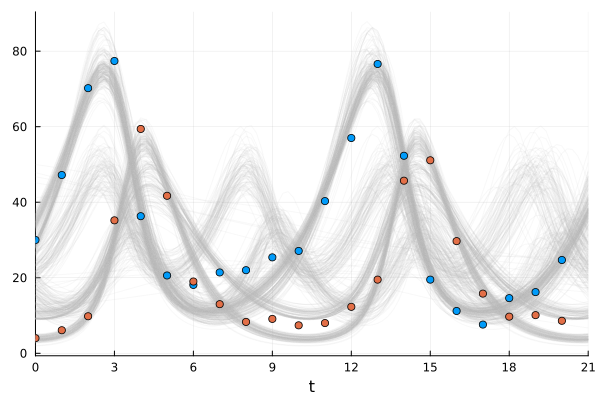

In [15]:
plot(; legend=false)
posterior_samples = sample(chain[[:x0,:y0,:α, :β, :γ, :δ]], 300; replace=false)
for row in eachrow(Array(posterior_samples))
    u0 = row[1:2]
    p = row[3:end]
    sol_p = solve(prob, Tsit5();u0=u0, p=p, saveat=0.2)
    plot!(sol_p; alpha=0.1, color="#BBBBBB")
end

# Plot simulation and noisy observations.
#plot!(sol; color=[1 2], linewidth=1)
scatter!(time.-1900, odedata'; color=[1 2])